In [40]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

df = pd.read_csv("../meteo_data.csv")
df.index = pd.to_datetime(df.DATE)
del df['DATE']

required_cols = ['HC_AIR_TEMPERATURE']
df = df[required_cols]
df

,HC_AIR_TEMPERATURE
DATE,
2021-05-30 16:00:00,21.71
2021-05-30 17:00:00,21.58
2021-05-30 18:00:00,21.17
2021-05-30 19:00:00,20.69
2021-05-30 20:00:00,19.74
...,...
2024-05-29 11:00:00,17.27
2024-05-29 12:00:00,18.16
2024-05-29 13:00:00,19.54


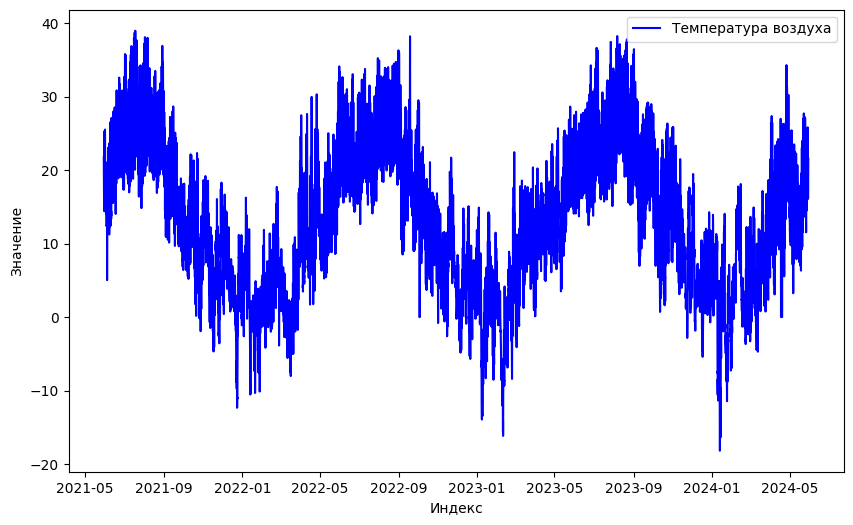

In [41]:
temp = df['HC_AIR_TEMPERATURE']

plt.figure(figsize=(10, 6))
plt.plot(df['HC_AIR_TEMPERATURE'], label='Температура воздуха', color='blue')

# Настройка графика
plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.legend()

# Показать график
plt.show()

In [58]:
# [[1], [2], [3], [4], [5], [6], [7], [8], [9], [10]]   [11]
# [[2], [3], [4], [5], [6], [7], [8], [9], [10], [11]]  [12]
# [[3], [4], [5], [6], [7], [8], [9], [10], [11], [12]] [13]
def df_to_X_y(df, window_size=24):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [[a] for a in df_as_np[i:i + window_size]]
        X.append(row)
        label = df_as_np[i + window_size]
        y.append(label)
    return np.array(X), np.array(y)

WINDOW_SIZE = 24
X1, y1 = df_to_X_y(temp, WINDOW_SIZE)

X_train1, y_train1 = X1[:20000], y1[:20000]
X_val1, y_val1 = X1[20000:23000], y1[20000:23000]
X_test1, y_test1 = X1[23000:], y1[23000:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((20000, 24, 1), (20000,), (3000, 24, 1), (3000,), (3241, 24, 1), (3241,))

In [68]:
model2 = Sequential()
model2.add(InputLayer((WINDOW_SIZE, 1)))
model2.add(LSTM(64, return_sequences=True))
model2.add(Dropout(0.5))
model2.add(LSTM(64, return_sequences=True))
model2.add(Dropout(0.5))
model2.add(LSTM(32))
model2.add(Dropout(0.5))
model2.add(Dense(16, activation='relu'))
model2.add(Dense(8, activation='relu'))
model2.add(Dense(1, activation='linear'))
model2.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                       │ (None, 24, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 24, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_16 (LSTM)                       │ (None, 24, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 24, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,009 (246.13 KB)

 Trainable params: 63,009 (246.13 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
# Настройки обратного вызова и компиляции модели
model_save_path = 'model2/model2-temperature.keras'
cp2 = ModelCheckpoint(model_save_path, save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [61]:
# Обучение модели
model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=50, callbacks=[cp2])

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - loss: 257.4481 - root_mean_squared_error: 16.0213 - val_loss: 50.5287 - val_root_mean_squared_error: 7.1159
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - loss: 88.9782 - root_mean_squared_error: 9.4016 - val_loss: 10.9551 - val_root_mean_squared_error: 3.3112
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - loss: 28.5427 - root_mean_squared_error: 5.3340 - val_loss: 5.5870 - val_root_mean_squared_error: 2.3634
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - loss: 17.6096 - root_mean_squared_error: 4.1949 - val_loss: 4.0231 - val_root_mean_squared_error: 2.0028
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - loss: 14.3102 - root_mean_squared_error: 3.7826 - val_loss: 3.4512 - val_root_mean_squared_error: 1.8513
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - loss: 12.7208 - root_mean_squared_error: 3.5664 - val_loss: 3.9940 - val_root_mean_squared_error: 1.9915
Epoch 7/50
625/625 ━━━━━━━━━━━

In [62]:
# Сохранение всей модели на диск
model_save_path = 'model2/model2-temperature.keras'
model2.save(model_save_path)
print(f"Модель сохранена в {model_save_path}")

Модель сохранена в model2/model2-temperature.keras


In [63]:
from keras.models import load_model
model2 = load_model('model2/model2-temperature.keras')

In [64]:
# Прогнозирование на тестовых данных
y_pred = model2.predict(X_test1)

# Вывод предсказаний
print(y_pred)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
[[ 1.5750614]
 [ 1.9787617]
 [ 3.5200539]
 ...
 [19.049072 ]
 [20.511768 ]
 [21.536396 ]]


In [65]:
# Прогнозирование на будущее
def predict_future(model, last_known_data, last_known_dates, steps=3, window_size=24):
    predictions = []
    future_dates = pd.date_range(start=last_known_dates[-1], periods=steps + 1, freq='h')[1:]
    
    current_data = last_known_data.tolist()
    
    for _ in range(steps):
        input_data = np.array(current_data[-window_size:]).reshape(1, window_size, 1)
        prediction = model.predict(input_data)
        predictions.append(prediction[0, 0])
        current_data.append(prediction[0, 0])
    
    return future_dates, predictions

# Последние известные данные и даты
last_known_data = temp.values[-WINDOW_SIZE:]
last_known_dates = temp.index[-WINDOW_SIZE:]

# Прогнозирование на 3 шага вперед
future_steps = 3
future_dates, predictions = predict_future(model2, last_known_data, last_known_dates, future_steps, WINDOW_SIZE)

# Вывод предсказаний с датами
for date, pred in zip(future_dates, predictions):
    print(f"{date}: {pred}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2024-05-29 16:00:00: 22.087846755981445
2024-05-29 17:00:00: 22.366901397705078
2024-05-29 18:00:00: 22.377208709716797


102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


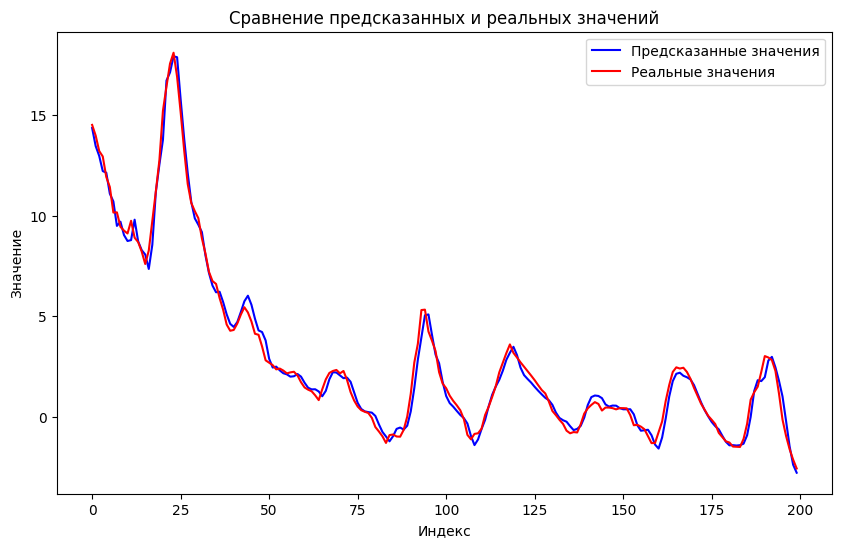

In [66]:
# Предсказание на тестовом наборе данных
y_pred1 = model2.predict(X_test1)

# Построение графика предсказанных и реальных значений
plt.figure(figsize=(10, 6))
plt.plot(y_pred1[700:900], label='Предсказанные значения', color='blue')
plt.plot(y_test1[700:900], label='Реальные значения', color='red')
plt.title('Сравнение предсказанных и реальных значений')
plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [67]:
# Оценка MAE
mae = mean_absolute_error(y_test1, y_pred1)

# Оценка MSE
mse = mean_squared_error(y_test1, y_pred1)

# Оценка RMSE
rmse = np.sqrt(mse)

# Оценка R^2
r2 = r2_score(y_test1, y_pred1)

print("Средняя абсолютная ошибка (MAE):", mae)
print("Средняя квадратичная ошибка (MSE):", mse)
print("Корень из среднеквадратичной ошибки (RMSE):", rmse)
print("Коэффициент детерминации (R^2):", r2)

Средняя абсолютная ошибка (MAE): 0.5979478717681547
Средняя квадратичная ошибка (MSE): 0.8755309687659536
Корень из среднеквадратичной ошибки (RMSE): 0.9356981183939367
Коэффициент детерминации (R^2): 0.9862189201443282
